###  Practical considerations

In [88]:
import numpy as np 
import scipy 
import scipy.stats 
import matplotlib.pyplot as plt 
from e4e import E4E 
e4e = E4E(chapter=8)

#### Violation of statistical assumptions

In [89]:
# Violation of independence
ind_means = np.array([1.5]*10)  # inadvertently collect same individual measurement multiple times
print(ind_means)
print(ind_means.mean())         # aggregate measurement
print(ind_means.std())          # standard error of aggregate measurement

[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
1.5
0.0


In [90]:
ind_means = np.array([1.5]*8 + [2.3, 3.1]) # run of repeats from sampling too quickly
print(ind_means)
print(ind_means.mean())
print(ind_means.std() / np.sqrt(10))

[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 2.3 3.1]
1.7400000000000002
0.16198765385053268


In [91]:
ind_means = np.array([1.5, 2.3, 3.1])       # sample correctly, ie only once per independent measurement
print(ind_means)
print(ind_means.mean())
print(ind_means.std() / np.sqrt(3))

[1.5 2.3 3.1]
2.3000000000000003
0.3771236166328254


#### Don't stop early

In [92]:
# Simulate an A/B test and monitor the z score
def z_score_vs_n():
    def profit_A():
        return np.random.uniform(0,1)               # profit_A, profit_B both from same distribution
    def profit_B():
        return np.random.uniform(0,1)               
    
    z_scores = []
    ind_measurements_A = []
    ind_measurements_B = []

    for n in range(1,100):
        ind_measurements_A.append(profit_A())       # store individual measure of profit
        ind_measurements_B.append(profit_B())       # store individual measure of profit
        a = np.array(ind_measurements_A)            # convert to ndarray
        b = np.array(ind_measurements_B)            # convert to ndarray
        delta = b.mean() - a.mean()                 # delta of aggregate measurements
        se_delta = np.sqrt(a.std()**2 + b.std()**2) / np.sqrt(n)  # n starts from 1, standard error
        z_scores.append(delta / se_delta)           # standardized score ie delta divided by standard error
    return np.array(z_scores)                       # z_score for each individual measurement

(array([12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43]),)


/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_4892/3180882758.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  z_scores.append(delta / se_delta)           # standardized score ie delta divided by standard error


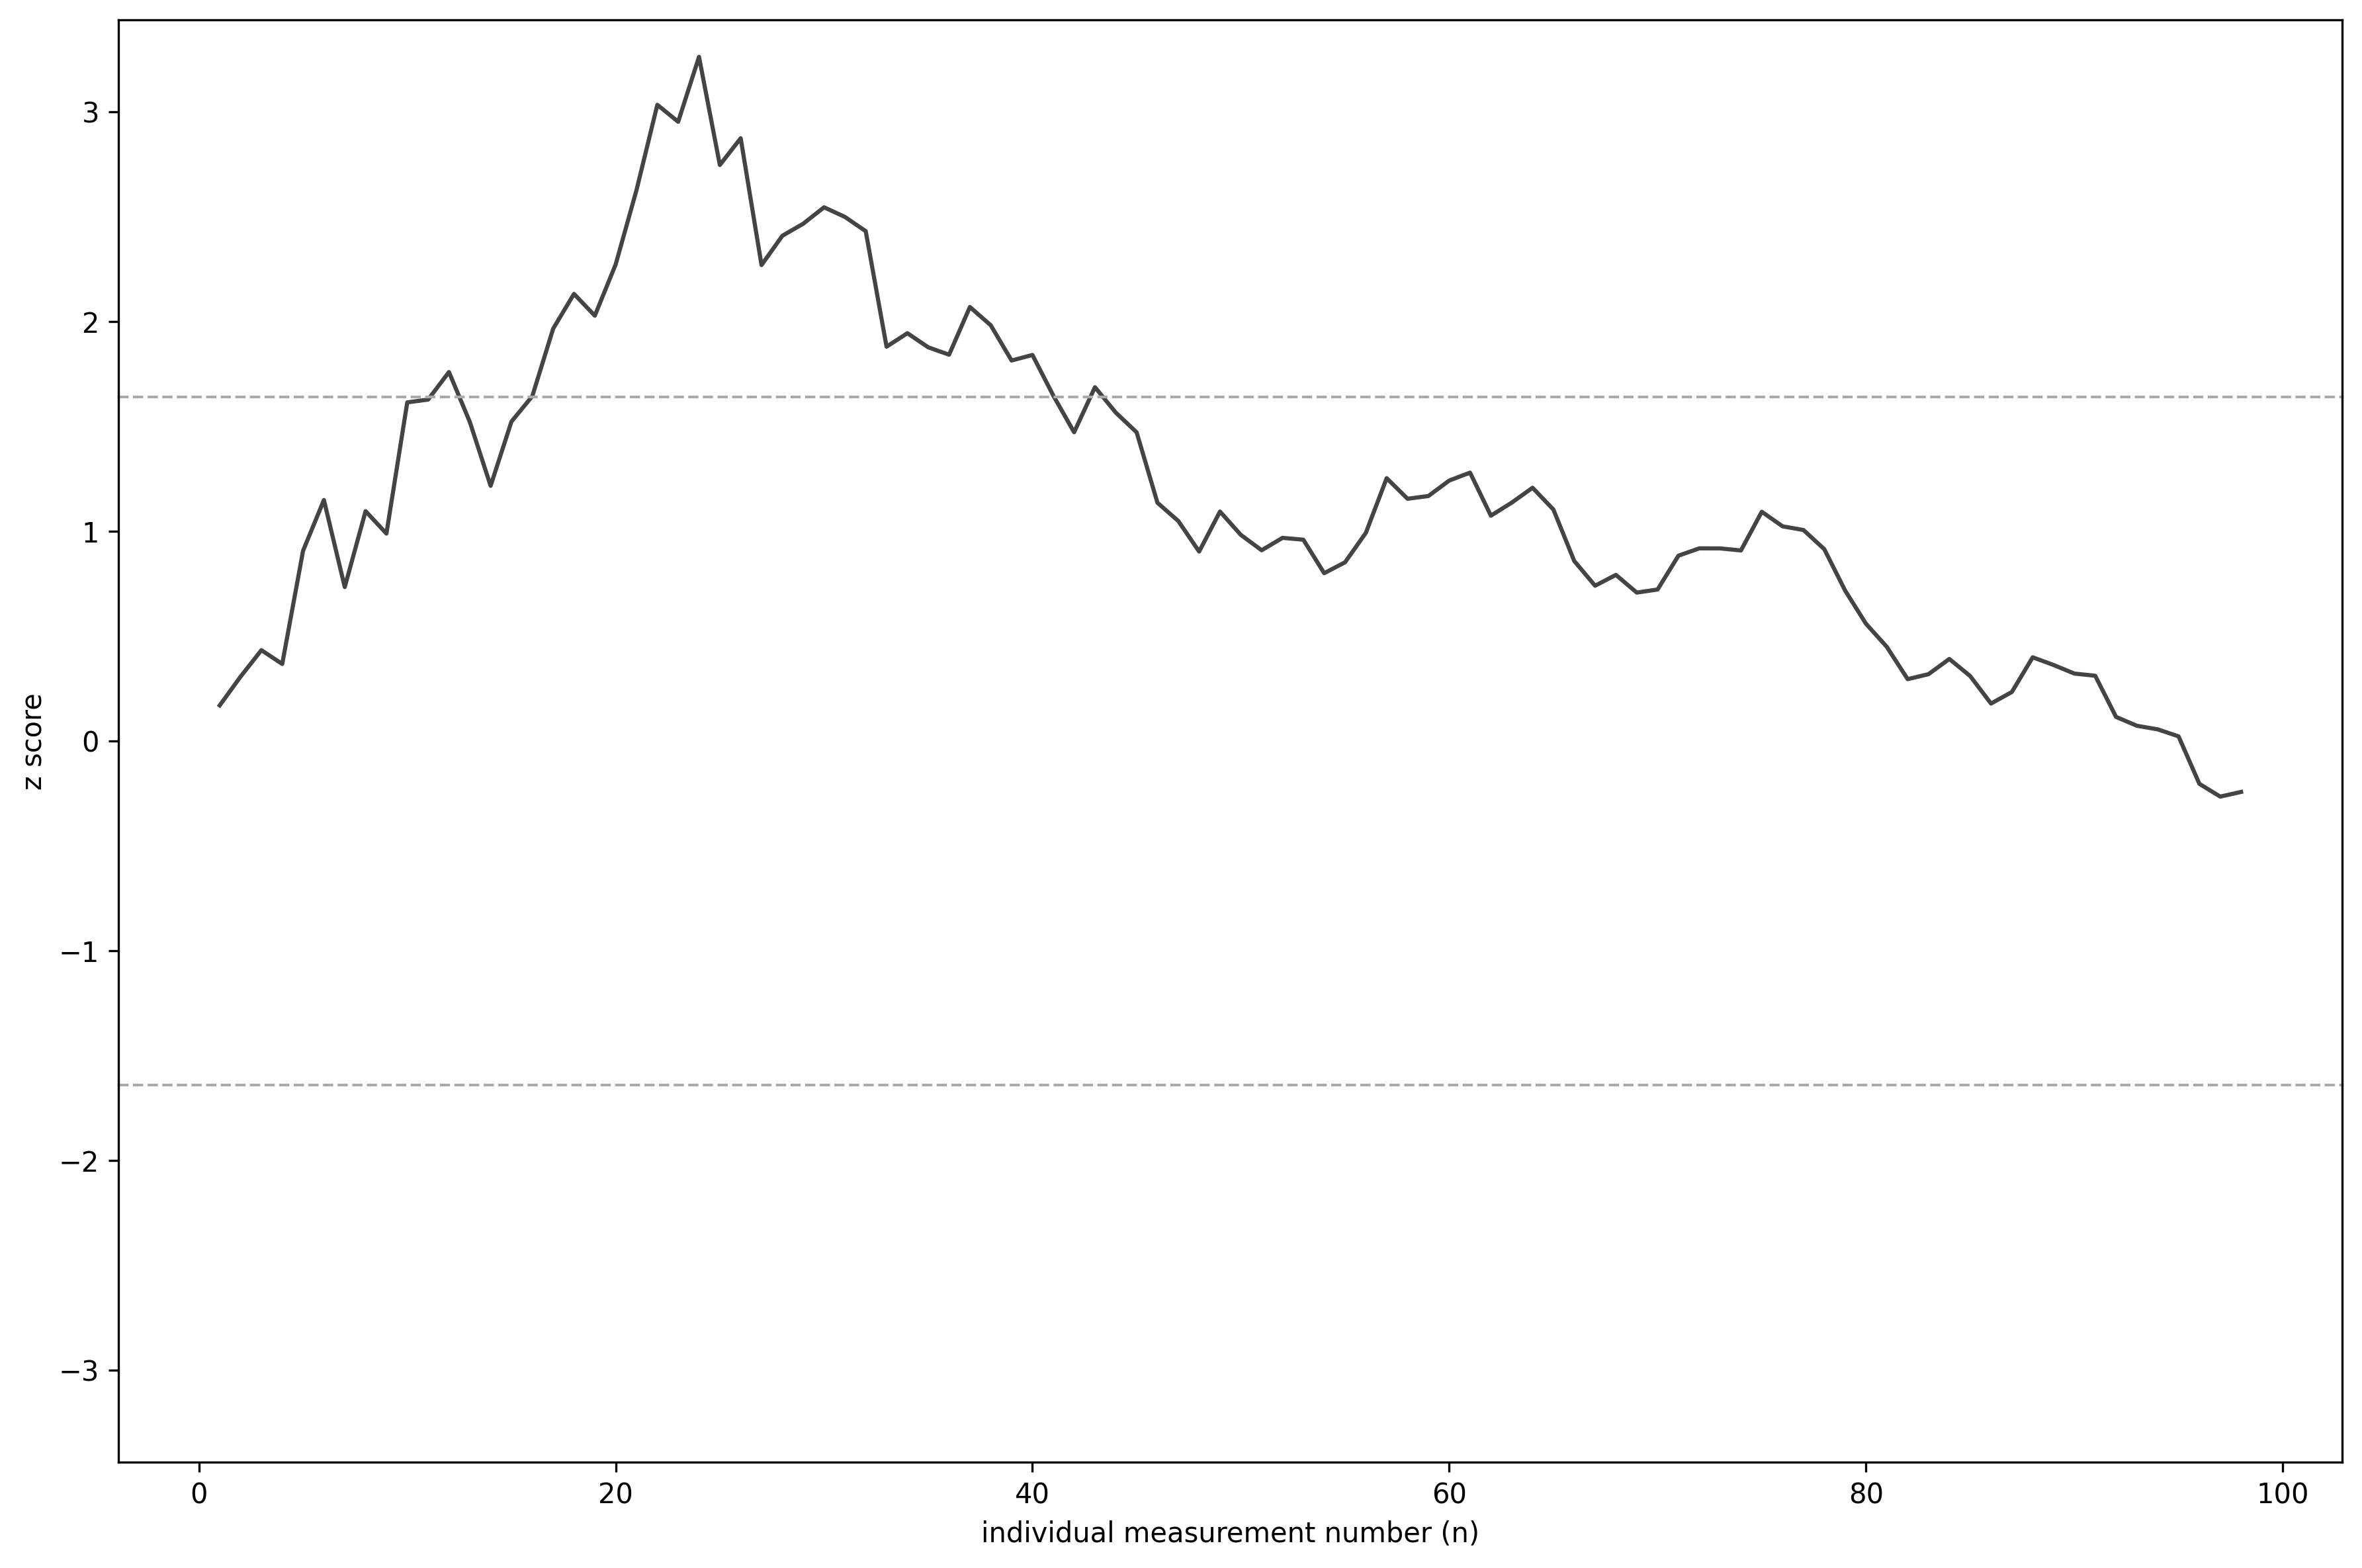

In [93]:
def do_fig(seed):
    np.random.seed(seed)
    z = z_score_vs_n()
    plt.figure(figsize=(12,8))
    plt.plot(z, color=e4e.color_1)
    e4e.horizontal_line(1.64)
    e4e.horizontal_line(-1.64)
    c = plt.axis()                            # get the current axis
    cy = max(abs(c[2]), abs(c[3]))            # choose the farthest y axis value
    plt.axis([c[0], c[1], -cy, cy])           # update the axis
    print(np.where(z > 1.64))
    plt.xlabel("individual measurement number (n)")
    plt.ylabel("z score")

do_fig(29)
plt.tight_layout()
plt.show()

/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_4892/3180882758.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  z_scores.append(delta / se_delta)           # standardized score ie delta divided by standard error


(array([ 0, 30]),)


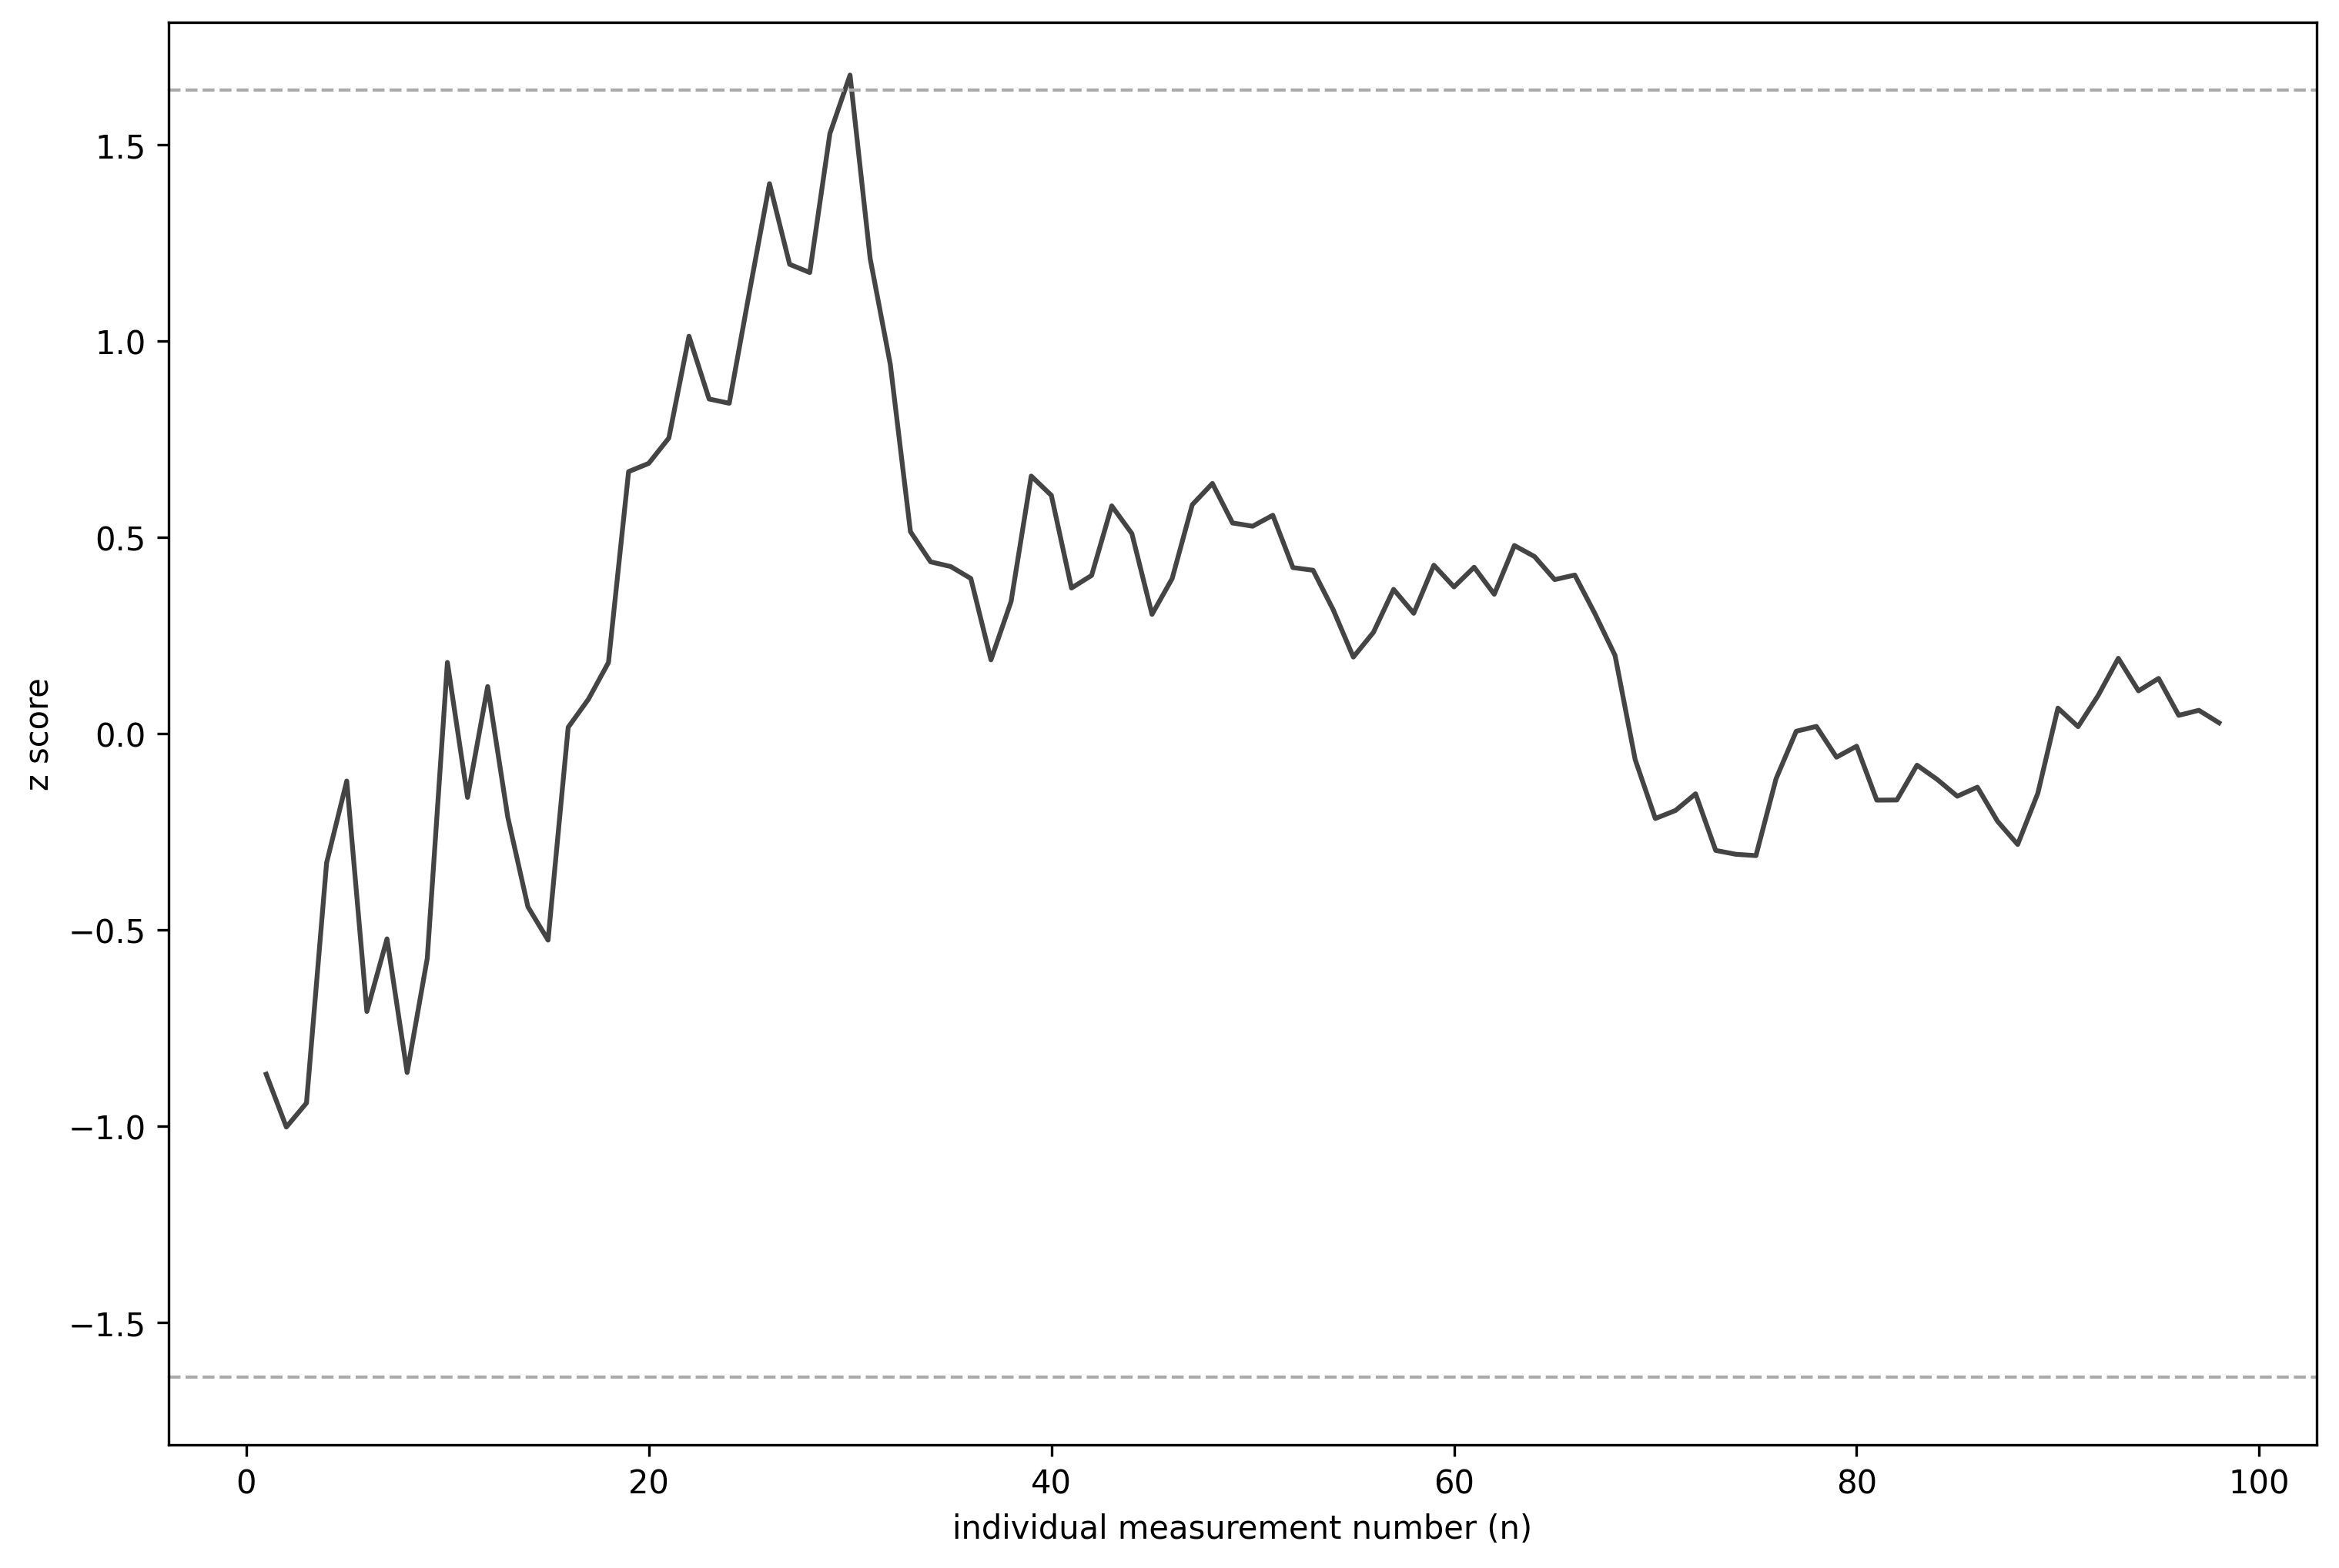

In [94]:
# Another simulation where early stopping would lead to a false positive
do_fig(39)
plt.show()

In [95]:
def z_score_vs_n_fast(N):
    a = np.random.uniform(size=(N,))        # individual measurements of system version a
    b = np.random.uniform(size=(N,))        # individual measurements of system version b
    N = np.arange(1, N+1)                   # number of measurements
    sx = np.cumsum(b - a)                   # delta, cumulative sum
    sxx= np.cumsum((b-a)**2)                # delta squared, cumulative sum
    mu = sx/N                               # delta divided by number of measurements at each step
    sd = np.sqrt(sxx/N - mu**2)             # standard error 
    z_score = np.sqrt(N) * mu/sd            # z_score?, not sure of this cumulative z-score computation
    return z_score 

def false_positive_rates(N):
    num_ab_tests = 10000
    fp_at_end = 0
    fp_with_early_stopping = 0
    for _ in range(num_ab_tests):
        z = z_score_vs_n_fast(N)            # get rolling window z_scores
        if z[-1] > 1.64:                    # if the last z-score value crosses A/B test threshold
            fp_at_end += 1                  # then false positive at end (5% A/B test fpr)
        i = np.where(abs(z[1:]) > 1.64)[0]  # from second measurement where z passed threshold
        if len(i) > 0:                      # if early z passed threshold
            fp_with_early_stopping += 1     # then false positive with early stopping
    return fp_at_end / num_ab_tests, fp_with_early_stopping / num_ab_tests # fpr rates, early stopping or not

In [96]:
np.random.seed(17)
false_positive_rates(100)

/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_4892/2566839933.py:9: RuntimeWarning: divide by zero encountered in divide
  z_score = np.sqrt(N) * mu/sd            # z_score?, not sure of this cumulative z-score computation


(0.0523, 0.8106)

In [97]:
np.random.seed(17)
fpr = []
for N in [10, 30, 100, 300, 1000, 3000, int(1e4)]:
    fp_0, fp_N = false_positive_rates(N)
    print(N, fp_0, fp_N)
    fpr.append((N, fp_0, fp_N))

/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_4892/2566839933.py:9: RuntimeWarning: divide by zero encountered in divide
  z_score = np.sqrt(N) * mu/sd            # z_score?, not sure of this cumulative z-score computation


10 0.0761 0.666
30 0.0558 0.7453
100 0.0487 0.8092
300 0.0491 0.8471
1000 0.0502 0.8896
3000 0.0516 0.9107
10000 0.0532 0.9348


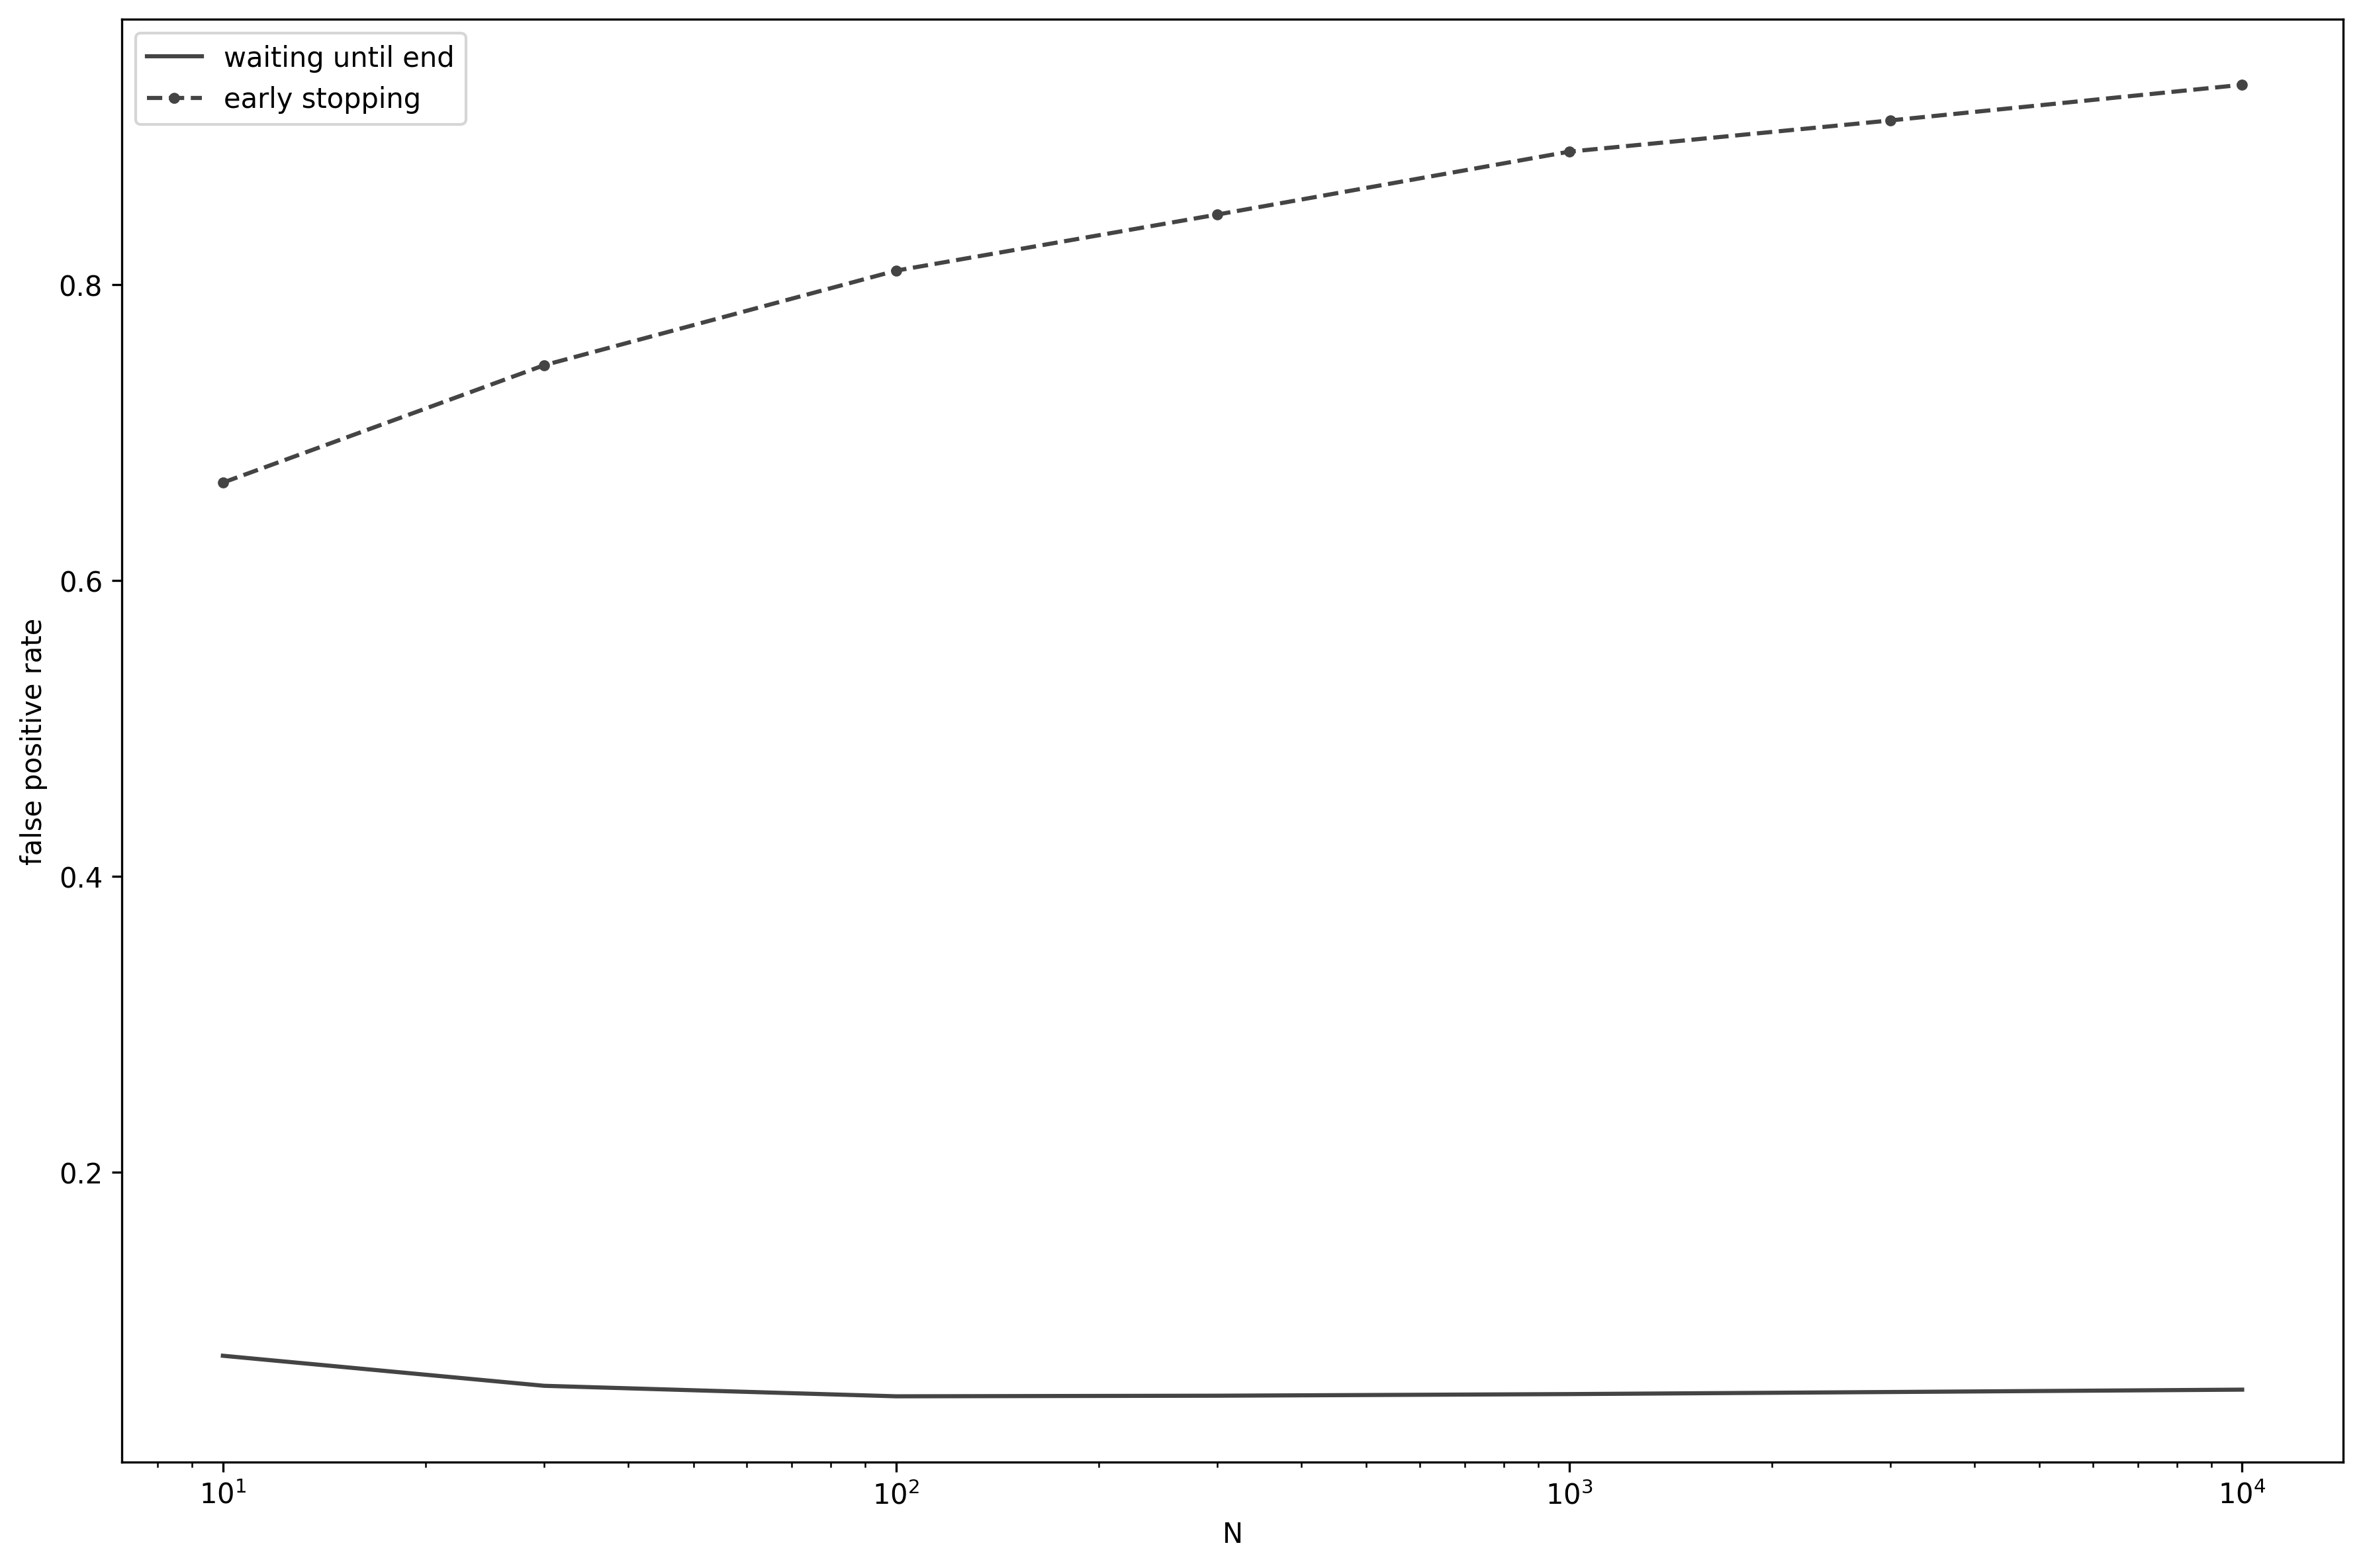

In [98]:
fpr = np.array(fpr)
plt.figure(figsize=(12,8))
plt.semilogx(fpr[:,0], fpr[:,1], '-', color=e4e.color_1)        # N vs fp_0 (false positive rate at end)
plt.semilogx(fpr[:,0], fpr[:,2], '.--', color=e4e.color_1)      # N vs fp_N (false positive rate early stopping)
plt.xlabel('N')
plt.ylabel('false positive rate')
plt.legend(['waiting until end', 'early stopping'])
plt.tight_layout()
plt.show()

#### Family-wise error: Cherry-picking increases false positive rate

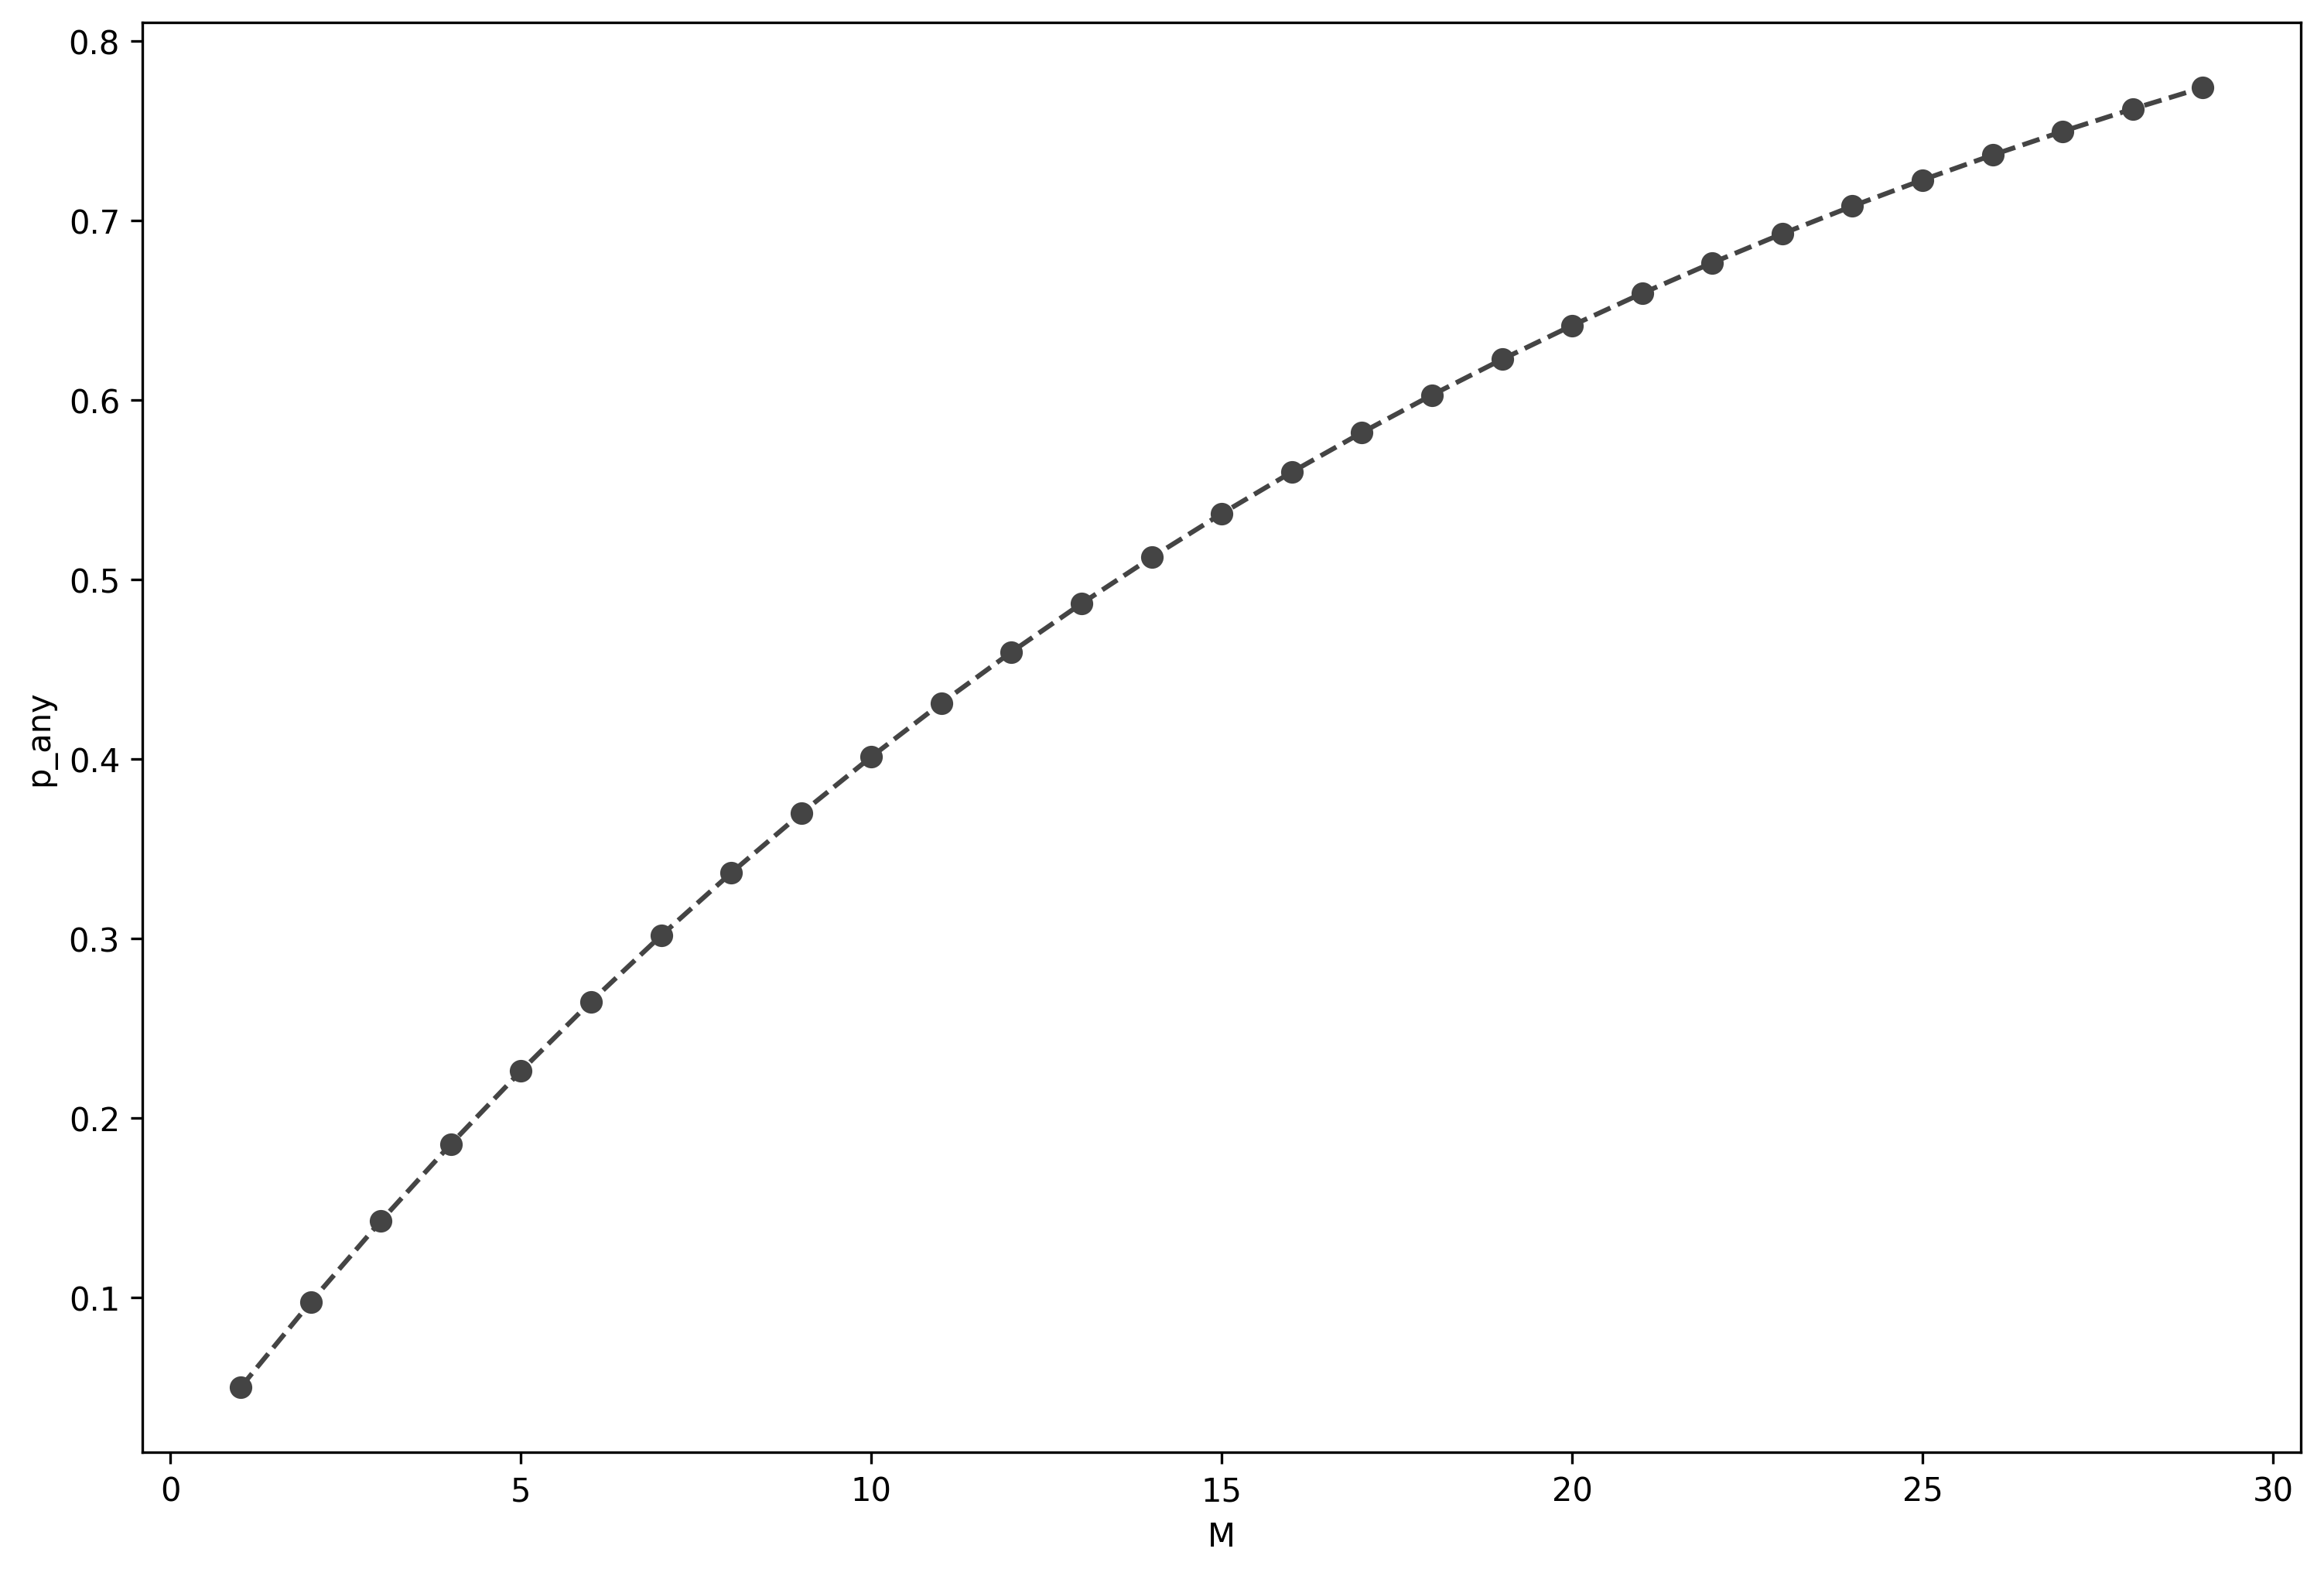

In [99]:
M = np.arange(1, 30)                                # number of metrics being monitored
plt.figure(figsize=(12,8))
plt.plot(M, 1- .95**M, 'o--', color=e4e.color_1)    # false positive rate as metrics increase
plt.xlabel('M')
plt.ylabel('p_any')         # probability of any metric yielding false positive if fpr of one metric is 0.05
plt.show()

In [100]:
1 - 0.95**10

0.4012630607616213

#### Control false positives with the Bonferroni correction

N_i >= ( (z_table(0.05/M) + .84) * sd1_delta_i / PS_i)**2

each metric has its own sd1_delta_i and PS_i

run A/B test with the largest N_i

z_i > z_table(0.05/M)

delta_i > PS_i

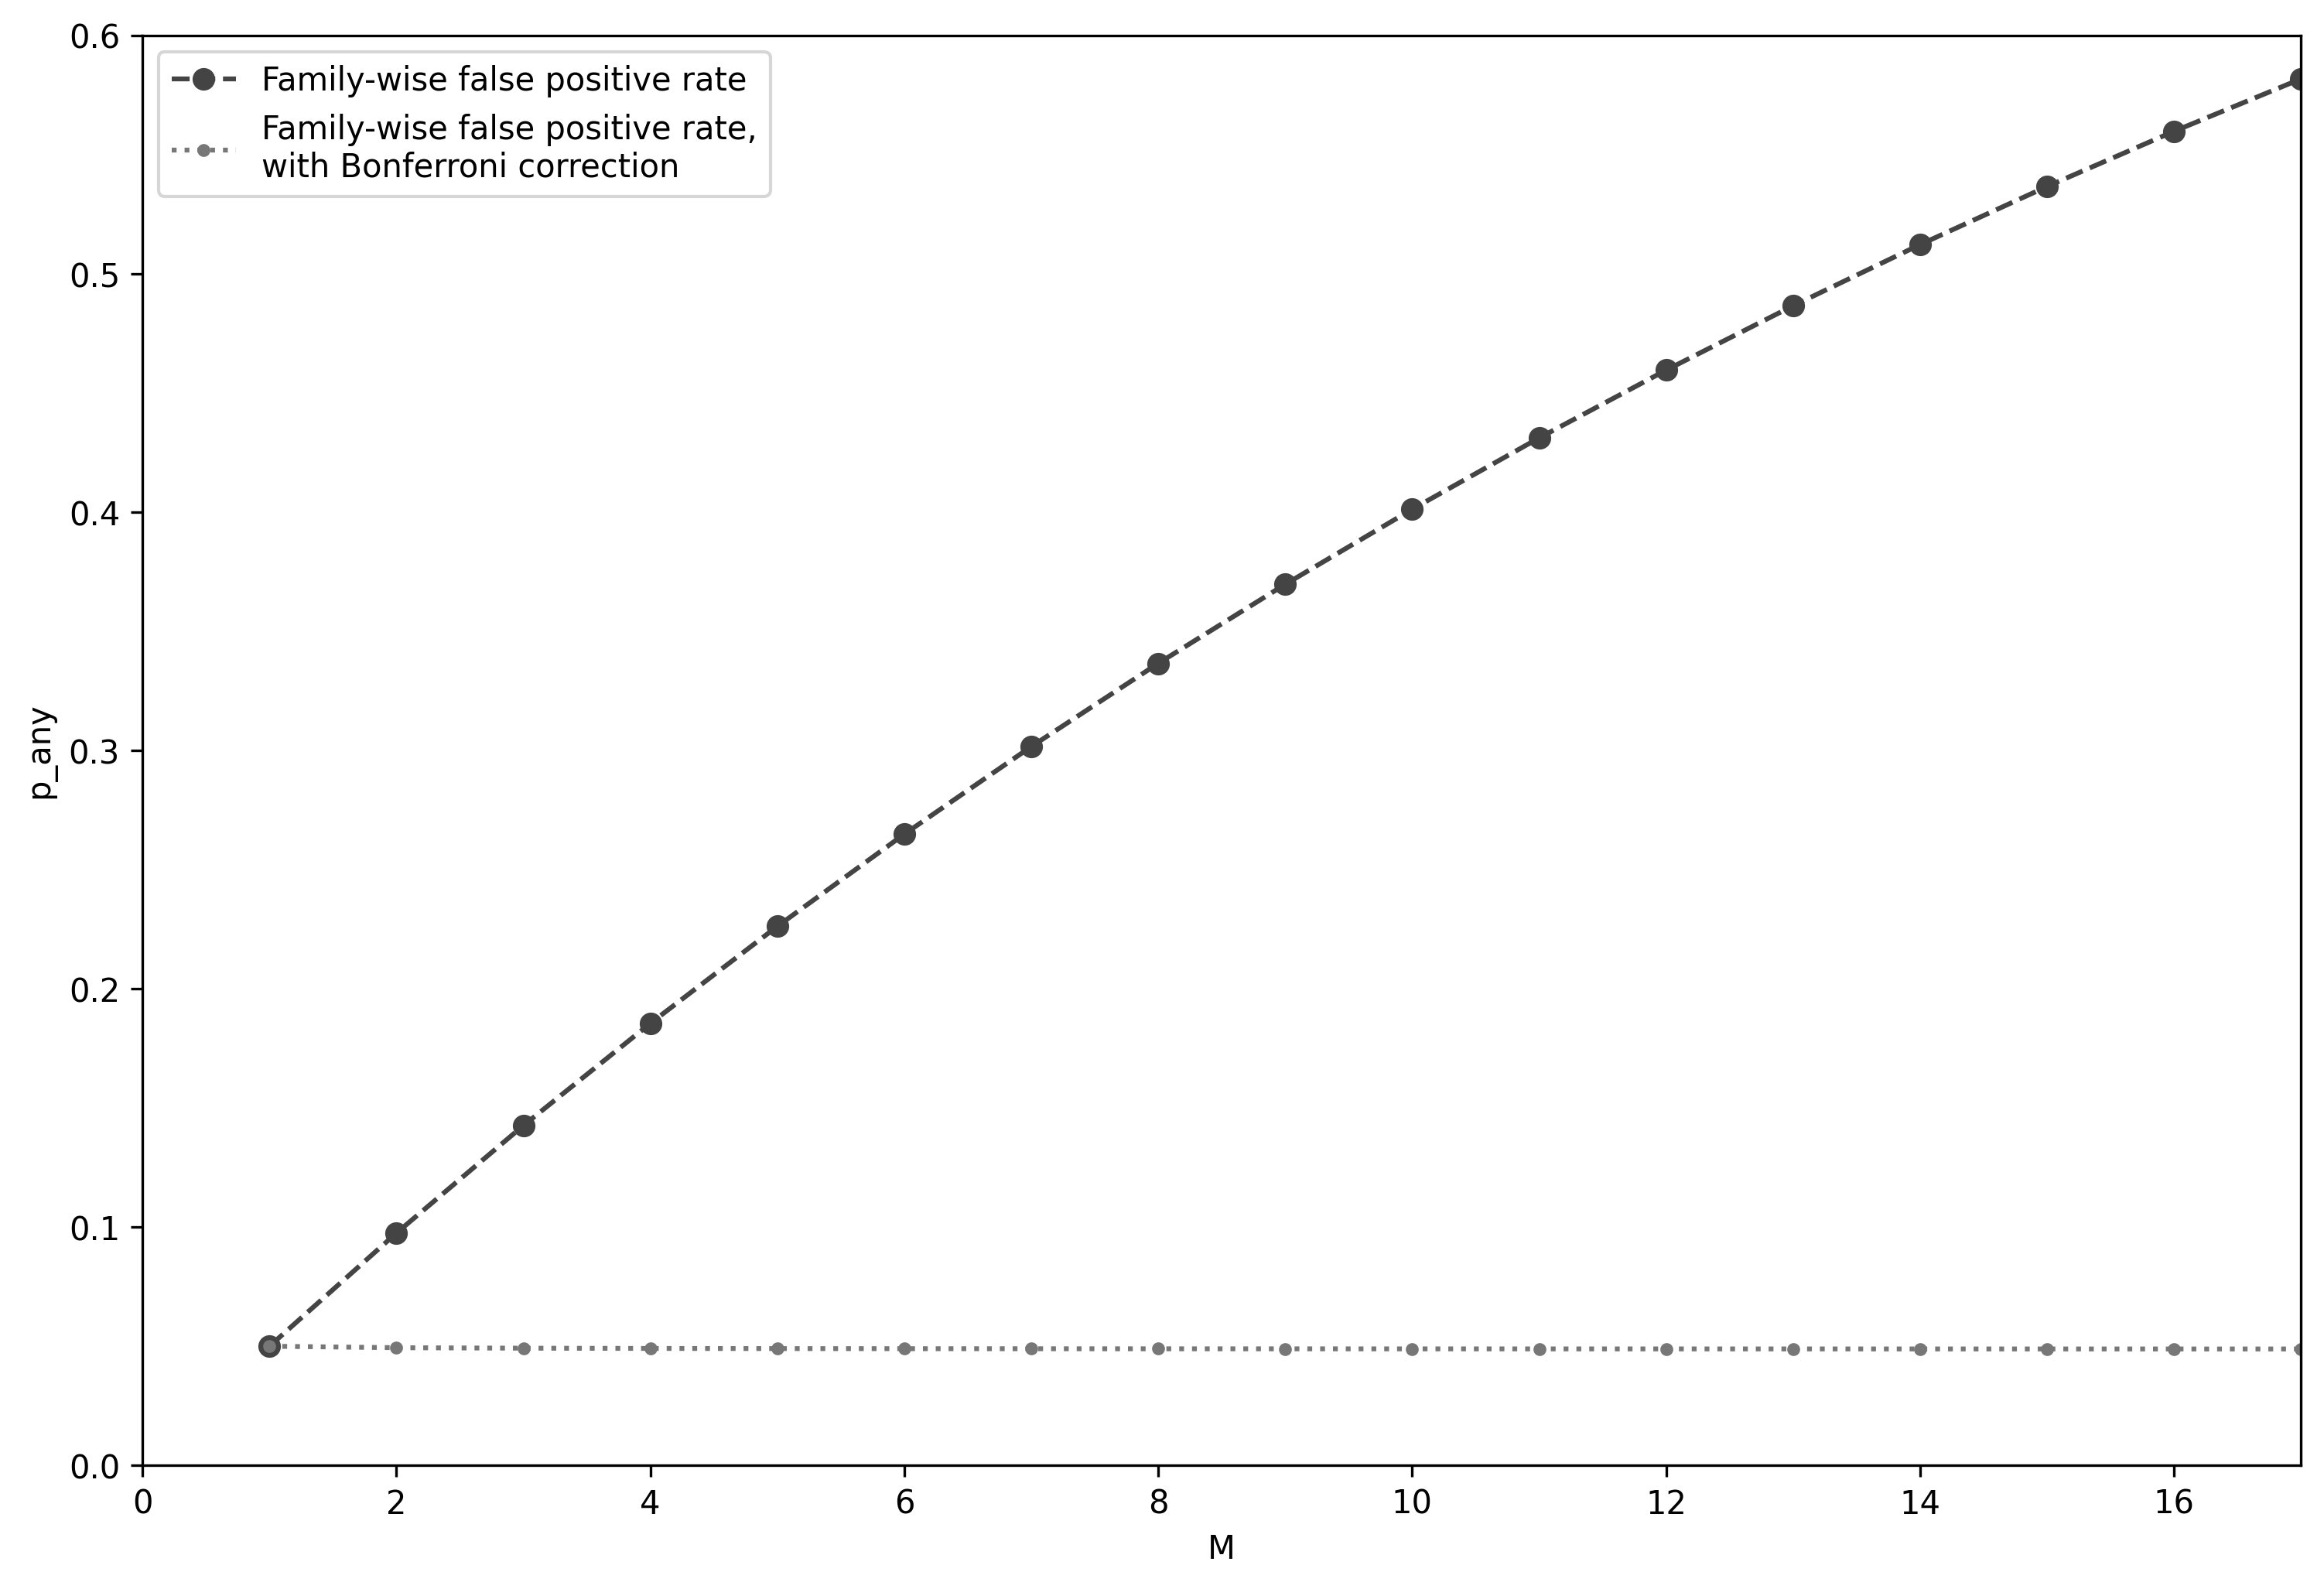

In [101]:
plt.figure(figsize=(12,8))
plt.plot(M, 1 - 0.95**M, 'o--',color=e4e.color_1)
plt.plot(M, 1 - (1 - 0.05/M)**M, '.:', color=e4e.color_2) # replace 0.95 ie (1-0.05) by (1- 0.05/M)
plt.xlabel('M')
plt.ylabel('p_any')
plt.legend(['Family-wise false positive rate', 'Family-wise false positive rate,\nwith Bonferroni correction'])
plt.axis([0, 17, 0, .6])
plt.show()


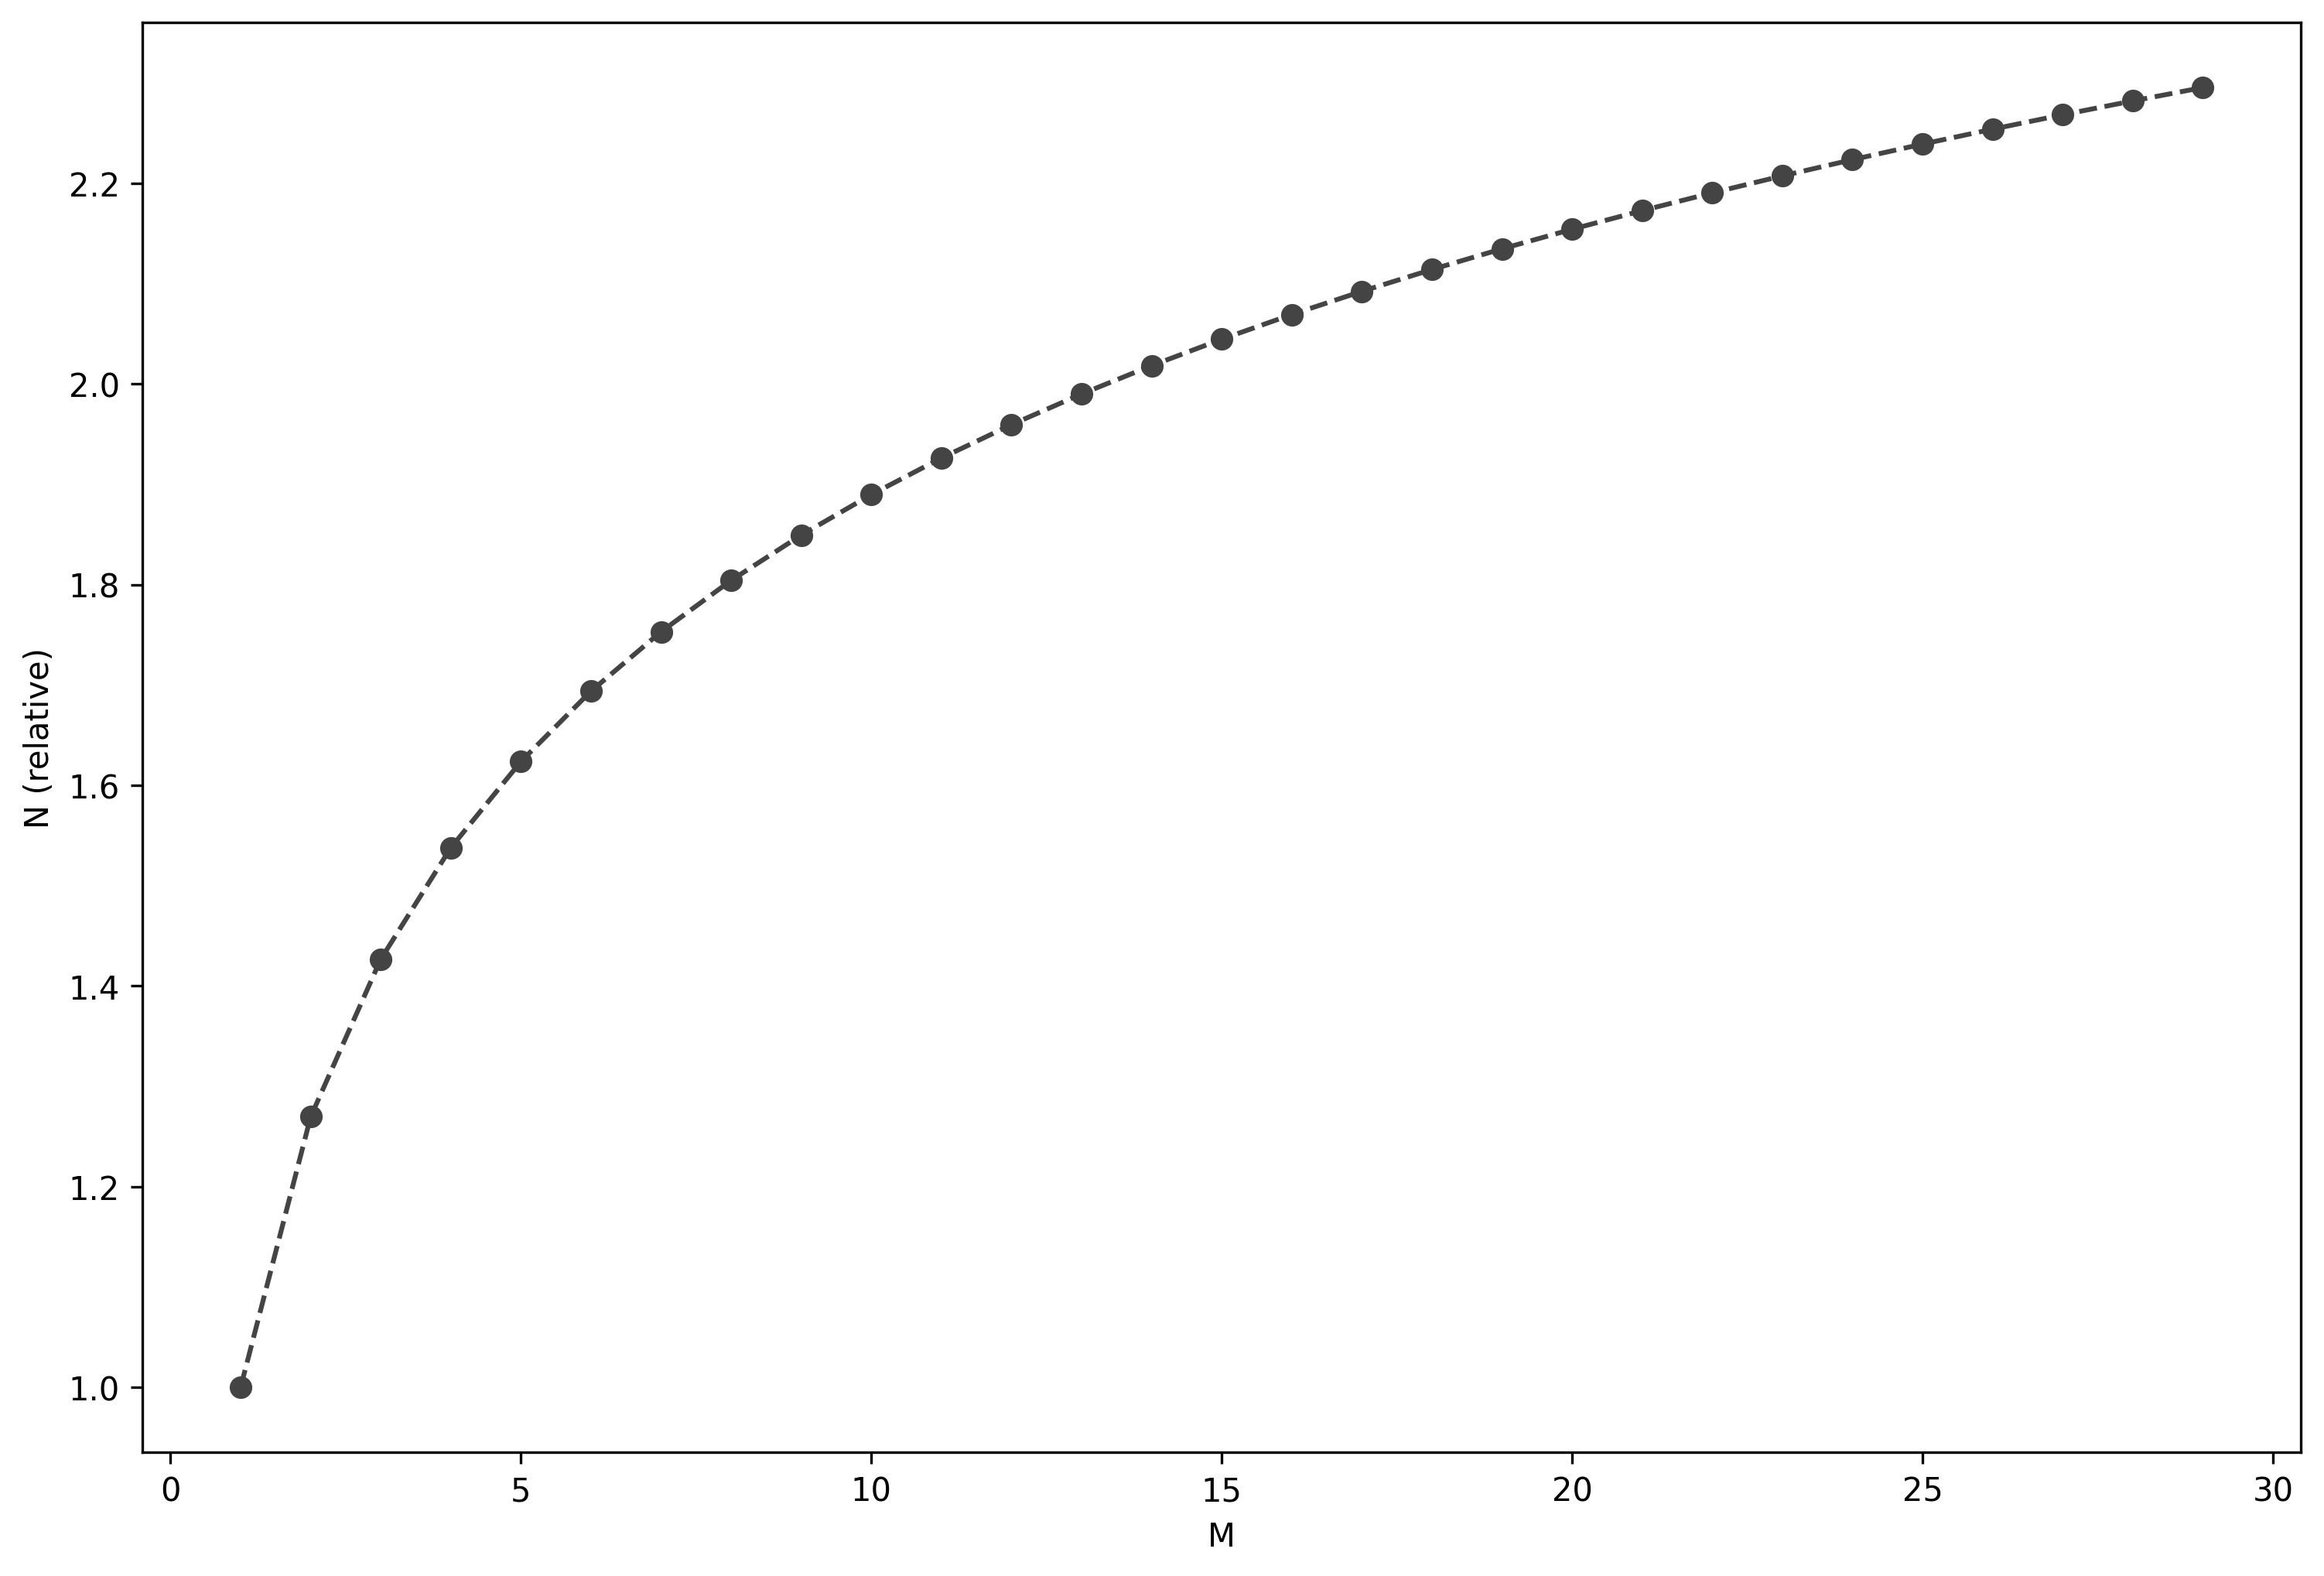

In [102]:
import scipy.stats as ss 

z = ss.norm()

vppf = np.vectorize(z.ppf)
N = ((.84 + vppf(1-0.05/M)))**2
N = N / N[0]                                    # relative

plt.figure(figsize=(12,8))
plt.plot(M, N, 'o--', color=e4e.color_1)
plt.xlabel('M')
plt.ylabel('N (relative)')
plt.show()